In [1]:
from utilities3 import *
from timeit import default_timer

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
import sys
import netCDF4 as nc
from data_loader_SSH_two_step import load_test_data
from data_loader_SSH_two_step import load_train_data
from count_trainable_params import count_parameters
import hdf5storage
from saveNCfile import savenc



2.0.1+cu117
2.0.1+cu117


In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
################################################################
# fourier layer
################################################################

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 8 # pad the domain if input is non-periodic

        self.p = nn.Linear(3, self.width) # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.norm(self.conv0(self.norm(x)))
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv1(self.norm(x)))
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv2(self.norm(x)))
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv3(self.norm(x)))
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 3, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)
    
    

def regular_loss(output, target):

 loss = torch.mean((output-target)**2)
 return loss

def ocean_loss(output, target, ocean_grid):

 loss = (torch.sum((output-target)**2))/ocean_grid
 return loss

def estimate_cyclone(output,target,mask):

    target_reshape = target[:,:,:,0]*mask
    output_reshape = output[:,:,:,0]*mask
#    index= (target_reshape >=0.17).nonzero(as_tuple = False)
    index= (target_reshape).ge(0.17)
    output_LC = torch.masked_select(output_reshape,index)
    target_LC = torch.masked_select(target_reshape,index)

    loss = torch.mean((output_LC - target_LC)**2)

    return loss
def estimate_anticyclone (output,target,mask):

    target_reshape = target[:,:,:,0]*mask
    output_reshape = output[:,:,:,0]*mask
#    index= (target_reshape >=0.17).nonzero(as_tuple = False)
    index= (target_reshape).le(-0.1)
    output_LC = torch.masked_select(output_reshape,index)
    target_LC = torch.masked_select(target_reshape,index)


#    output_LC = torch.cat([output_reshape[xs,ys,zs].unsqueeze(0) for xs,ys,zs in zip(index[:,0],index[:,1],index[:,2])])
#    target_LC = torch.cat([target_reshape[xs,ys,zs].unsqueeze(0) for xs,ys,zs in zip(index[:,0],index[:,1],index[:,2])])

#    output_LC = torch.index_select(output_reshape,0,index)
#    target_LC = torch.index_select(target_reshape,0,index)

    loss = torch.mean((output_LC - target_LC)**2)

    return loss

def spectral_loss(output, output2, target, target2, wavenum_init,wavenum_init_ydir,lamda_reg,ocean_grid):

 loss1 = torch.sum((output-target)**2)/ocean_grid + torch.sum((output2-target2)**2)/ocean_grid
# loss1 = torch.abs((output-target))/ocean_grid

 out_fft = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,0],dim=2)),dim=1)
 target_fft = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,0],dim=2)),dim=1)

 out_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,0],dim=1)),dim=2)
 target_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,0],dim=1)),dim=2)


 out2_fft = torch.mean(torch.abs(torch.fft.rfft(output2[:,:,:,0],dim=2)),dim=1)
 target2_fft = torch.mean(torch.abs(torch.fft.rfft(target2[:,:,:,0],dim=2)),dim=1)

 out2_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(output2[:,:,:,0],dim=1)),dim=2)
 target2_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(target2[:,:,:,0],dim=1)),dim=2)


# loss2 = torch.mean(torch.abs(out_fft[:,0:wavenum_init]-target_fft[:,0:wavenum_init]))
# loss2_ydir = torch.mean(torch.abs(out_fft_ydir[:,0:wavenum_init_ydir]-target_fft_ydir[:,0:wavenum_init_ydir]))

 loss2 = torch.mean(torch.abs(out_fft[:,wavenum_init:]-target_fft[:,wavenum_init:]))
 loss2_ydir = torch.mean(torch.abs(out_fft_ydir[:,wavenum_init_ydir:]-target_fft_ydir[:,wavenum_init_ydir:]))

# LC_loss_cyclone = estimate_cyclone (output,target,mask_rho_torch)
# LC_loss_anticyclone = estimate_anticyclone (output,target,mask_rho_torch)

 loss2_next_time = torch.mean(torch.abs(out2_fft[:,wavenum_init:]-target2_fft[:,wavenum_init:]))
 loss2_ydir_next_time = torch.mean(torch.abs(out2_fft_ydir[:,wavenum_init_ydir:]-target2_fft_ydir[:,wavenum_init_ydir:]))


# loss = (1-lamda_reg)*loss1 + 0.33*lamda_reg*loss2 + 0.33*lamda_reg*loss2_ydir + 0.33*LC_loss
 loss = ((1-lamda_reg)*loss1 + 0.25*(lamda_reg)*loss2 + 0.25*(lamda_reg)*loss2_ydir + 0.25*(lamda_reg)*loss2_next_time+0.25*(lamda_reg)*loss2_ydir_next_time)

 return loss

def RK4step(net,input_batch):
 output_1 = net(input_batch.cuda())
 output_2= net(input_batch.cuda()+0.5*output_1)
 output_3 = net(input_batch.cuda()+0.5*output_2)
 output_4 = net(input_batch.cuda()+output_3)

 return input_batch.cuda() + (output_1+2*output_2+2*output_3+output_4)/6


def Eulerstep(net,input_batch, delta_t=1.0):
 output_1 = net(input_batch.cuda())
 return input_batch.cuda() + delta_t*(output_1)


def PECstep(net,input_batch, delta_t=1.0):
 output_1 = net(input_batch.cuda()) + input_batch.cuda() 
 return input_batch.cuda() + delta_t*0.5*(net(input_batch.cuda())+net(output_1))

def directstep(net,input_batch):
  output_1 = net(input_batch.cuda())
  return output_1

In [4]:
################################################################
# configs
################################################################
data_path = '/data/ODAP_datastore/ocean_data/'
model_path = '/data/ODAP_datastore/ML_models/'

FF=nc.Dataset(data_path + 'EnKF_surface_2020_5dmean_gom.nc')

mask_rho = np.asarray(FF['mask_rho'])
mask_rho_torch= torch.from_numpy(mask_rho).float().cuda()

lead = 5
delta_t = 1.0

psi_test_input_Tr_torch, psi_test_label_Tr_torch,ocean_gridsize  = load_test_data(FF,lead)

# psi_test_input_Tr_torch = torch.ones([360,1,240,424])
# psi_test_label_Tr_torch = torch.ones([360,1,240,424])

# psi_test_input_Tr_torch = psi_test_input_Tr_torch[:,:,1:100,1:100]
# psi_test_label_Tr_torch = psi_test_label_Tr_torch[:,:,1:100,1:100]

M_test_level1=torch.mean((psi_test_input_Tr_torch.flatten()))
STD_test_level1=torch.std((psi_test_input_Tr_torch.flatten()))


psi_test_input_Tr_torch_norm_level1 = ((psi_test_input_Tr_torch[:,0,None,:,:]-M_test_level1)/STD_test_level1)
psi_test_label_Tr_torch_norm_level1 = ((psi_test_label_Tr_torch[:,0,None,:,:]-M_test_level1)/STD_test_level1)

print('mean value',M_test_level1)
print('std value',STD_test_level1)
print('ocean grid size', ocean_gridsize)

mean value tensor(0.1453)
std value tensor(0.3003)
ocean grid size 107661


In [5]:
psi_test_label_Tr = psi_test_label_Tr_torch.detach().cpu().numpy()
Nlat = np.size(psi_test_label_Tr,2)
Nlon = np.size(psi_test_label_Tr,3)

batch_size = 10 
num_epochs = 100
num_samples = 2

lamda_reg =0.9
wavenum_init=50
wavenum_init_ydir=50

modes = 128
width = 20

batch_size = 5
learning_rate = 0.001

In [6]:
net = FNO2d(modes, modes, width).cuda()
print(count_parameters(net))
net.load_state_dict(torch.load(model_path + 'BNN_FNO2D_two_step__loss_PECstep_SSH_ocean_spectral_loss_modes_128_wavenum50delta_t_1.0lead5_lambda0.3.pt'))
net.eval()

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|     p.weight     |     60     |
|      p.bias      |     20     |
|  conv0.weights1  |  6553600   |
|  conv0.weights2  |  6553600   |
|  conv1.weights1  |  6553600   |
|  conv1.weights2  |  6553600   |
|  conv2.weights1  |  6553600   |
|  conv2.weights2  |  6553600   |
|  conv3.weights1  |  6553600   |
|  conv3.weights2  |  6553600   |
| mlp0.mlp1.weight |    400     |
|  mlp0.mlp1.bias  |     20     |
| mlp0.mlp2.weight |    400     |
|  mlp0.mlp2.bias  |     20     |
| mlp1.mlp1.weight |    400     |
|  mlp1.mlp1.bias  |     20     |
| mlp1.mlp2.weight |    400     |
|  mlp1.mlp2.bias  |     20     |
| mlp2.mlp1.weight |    400     |
|  mlp2.mlp1.bias  |     20     |
| mlp2.mlp2.weight |    400     |
|  mlp2.mlp2.bias  |     20     |
| mlp3.mlp1.weight |    400     |
|  mlp3.mlp1.bias  |     20     |
| mlp3.mlp2.weight |    400     |
|  mlp3.mlp2.bias  |     20     |
|    w0.weight

FNO2d(
  (p): Linear(in_features=3, out_features=20, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (mlp0): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp1): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp2): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp3): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (w0): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (norm): InstanceNo

In [7]:
psi_test_label_Tr_torch_denorm = psi_test_label_Tr_torch_norm_level1*STD_test_level1+M_test_level1
psi_test_label_Tr = psi_test_label_Tr_torch_denorm.detach().cpu().numpy()

In [8]:
def get_lat_lon():
    FF=nc.Dataset(data_path + 'EnKF_surface_2020_5dmean_gom.nc')
    lat_vals = np.asarray(FF['lat_rho'])
    lon_vals = np.asarray(FF['lon_rho'])
    
    return lat_vals, lon_vals

lat_vals, lon_vals = get_lat_lon()

In [104]:
# ELEMENT WISE ENKF
sig_m = 2.0

def EnKF(prior_x,obs):
    
    # sig_m= 5  # standard deviation for measurement noise
    # R = sig_m**2*np.eye(Nlat*Nlon,Nlat*Nlon)
    
    # The analysis step for the (stochastic) ensemble Kalman filter with virtual observations
    N = np.size(prior_x,1)
    n=Nlat*Nlon

    # compute the mean of forecast ensemble
    prior_x_mean = np.mean(prior_x,1)   
    
    div_num = 100
    div_size = int(Nlat*Nlon/div_num)
    prior_P = np.zeros(Nlat*Nlon)
    for i in range(div_num):
        prior_P[i*div_size:(i+1)*div_size] = np.diag((1/(N-1)) * (prior_x[i*div_size:(i+1)*div_size,:] - prior_x_mean[i*div_size:(i+1)*div_size].reshape(-1,1)) @ (prior_x[i*div_size:(i+1)*div_size,:] - prior_x_mean[i*div_size:(i+1)*div_size].reshape(-1,1)) .T)
    
    print('Inside KF, prior_x',np.shape(prior_x))
    
    # compute Jacobian of observation operator at ub
    # C_obs = np.eye(n,n)
    # m = np.size(C_obs,0)
    
    # # compute Kalman gain
    # D = C_obs@prior_P@C_obs.T + R
    # K = prior_P @ C_obs.T @ np.linalg.inv(D)
    
    D = prior_P + sig_m**2
    K = prior_P*(1/D)
    print('Inside KF, K',np.shape(K))    
    
    m=n
    obsi = np.zeros([m,N])
    state_updated = np.zeros([n,N])
    for i in range(N):
        # create virtual observations
        obsi[:,i] = obs + np.random.normal(0,sig_m,[Nlat*Nlon,])
        # compute analysis ensemble
        state_updated[:,i] = prior_x[:,i] + K * (obsi[:,i] - prior_x[:,i])
        
    print('Inside KF, updated_states',np.shape(state_updated))
    
    # compute the mean of analysis ensemble
    state_updated_mean = np.mean(state_updated,1)    
    print('Inside KF, updated_states_mean',np.shape(state_updated_mean))

    # compute analysis error covariance matrix
    P_updated = np.zeros(Nlat*Nlon)
    for i in range(div_num):
        P_updated[i*div_size:(i+1)*div_size] = np.diag((1/(N-1)) * (state_updated[i*div_size:(i+1)*div_size,:] - state_updated_mean[i*div_size:(i+1)*div_size].reshape(-1,1)) @ (state_updated[i*div_size:(i+1)*div_size,:] - state_updated_mean[i*div_size:(i+1)*div_size].reshape(-1,1)) .T)
    
    return state_updated, P_updated, prior_P

In [105]:
DA_cycles = 2
obs_psi = np.zeros([int(np.size(psi_test_label_Tr,0)/(DA_cycles*lead))+1,1,Nlat,Nlon])
obs_count=0
for k in range((DA_cycles-1)*lead,np.size(psi_test_label_Tr,0),DA_cycles*lead):
    obs_psi[obs_count,:,:,:] = psi_test_label_Tr[k,:,:,:]
    obs_count=obs_count+1
    

actual_psi_test = np.zeros([int(np.size(psi_test_label_Tr,0)/lead)+1,1,Nlat,Nlon])
obs_count=0
for k in range(0,np.size(psi_test_label_Tr,0),lead):
    actual_psi_test[obs_count,:,:,:] = psi_test_label_Tr[k,:,:,:]
    obs_count=obs_count+1
# np.save('actual_psi_test.npy', actual_psi_test)

N = 100
print('number of points in ensemble',N)

T = 20
sig_init= sig_m
# sig_init= 0.25
# var_init = sig_init**2*np.eye(Nlat*Nlon,Nlat*Nlon)

psi0 = psi_test_input_Tr_torch_norm_level1[0,:,0:Nlat,0:Nlon].reshape([1,1,Nlat,Nlon])

pred_psi = np.zeros([N,1,Nlat,Nlon])
psi_ensemble = np.zeros([Nlat*Nlon,N])
pred_psi_ensemble = np.zeros([Nlat*Nlon,N])
pred_psi_ensemble_denorm = np.zeros([Nlat*Nlon,N])

updated_psi_mean =  np.zeros([T+1,1,Nlat,Nlon])

# M_test_level1 = M_test_level1.detach().cpu().numpy()
# STD_test_level1 = STD_test_level1.detach().cpu().numpy()



number of points in ensemble 100


In [106]:
actual_psi_test.shape

(73, 1, 314, 425)

In [107]:
#%% Normal propogation

autoreg_pred = np.zeros([T+1,1,Nlat,Nlon])

psi0_noisy = (psi0.flatten()+np.random.normal(0,sig_m,[Nlat*Nlon,]))
# psi0_noisy = (psi0_noisy-M_test_level1)/STD_test_level1

for k in range(0,T+1):

  if (k==0):

    out = (PECstep(net,((psi0_noisy.reshape([1,1,Nlat,Nlon])).float()).permute(0,2,3,1).cuda()))
    autoreg_pred[k,:,:,:] = (out.permute(0,3,1,2)).detach().cpu().numpy()

  else:

    out = (PECstep(net,(torch.from_numpy(autoreg_pred[k-1,:,0:Nlat,0:Nlon].reshape([1,1,Nlat,Nlon])).float()).permute(0,2,3,1).cuda()))
    autoreg_pred[k,:,:,:] = (out.permute(0,3,1,2)).detach().cpu().numpy()
    
M_test_level1 = M_test_level1.detach().cpu().numpy()
STD_test_level1 = STD_test_level1.detach().cpu().numpy()sig_init

autoreg_pred = autoreg_pred*STD_test_level1+M_test_level1
# np.save('autoreg_pred.npy', autoreg_pred)

SyntaxError: invalid syntax (2202953453.py, line 21)

In [108]:
#%% EnKF propogation

count = 0
t = 0

div_num = 100
div_size = int(Nlat*Nlon/div_num)

while (t<T+1):
    print(t)
    if (t==0): 
        
####### Generate ensembles ####################################################    
        for k in range(0,N):
            psi_ensemble[:,k] = (psi0.flatten()+np.random.normal(0,sig_init,[Nlat*Nlon,]))
            
            # psi_ensemble_norm = (psi_ensemble-M_test_level1)/STD_test_level1
                            
######### Evolve ensembles #################################################### 
        for k in range(0,N):
            pred_psi_1 = (PECstep(net,(torch.from_numpy(psi_ensemble[:,k].reshape([1,1,Nlat,Nlon])).float()).permute(0,2,3,1).cuda()))
            pred_psi[k,:,:,:] = (pred_psi_1.permute(0,3,1,2)).detach().cpu().numpy()
            
            pred_psi_ensemble[:,k] = pred_psi[k,:,:,:].reshape([1,1,Nlat,Nlon]).flatten()
            pred_psi_ensemble_denorm[:,k]  = pred_psi_ensemble[:,k]*STD_test_level1+M_test_level1
        
#### Start ENKF ################    
        if DA_cycles == 1:
            updated_psi_ensemble, updated_P, prior_P = EnKF(pred_psi_ensemble_denorm,obs_psi[count,:,:,:].flatten())
            updated_psi_mean[t,:,:,:]=(np.mean(updated_psi_ensemble,1)).reshape([1,1,Nlat,Nlon])
            count = count+1
        else:
            pred_psi_ensemble_denorm_mean = np.mean(pred_psi_ensemble_denorm,1)
            updated_psi_mean[t,:,:,:]=pred_psi_ensemble_denorm_mean.reshape([1,1,Nlat,Nlon])        
            
            updated_P = np.zeros(Nlat*Nlon)
            for i in range(div_num):
                updated_P[i*div_size:(i+1)*div_size] = np.diag((1/(N-1)) * (pred_psi_ensemble_denorm[i*div_size:(i+1)*div_size,:] - pred_psi_ensemble_denorm_mean[i*div_size:(i+1)*div_size].reshape(-1,1)) @ (pred_psi_ensemble_denorm[i*div_size:(i+1)*div_size,:] - pred_psi_ensemble_denorm_mean[i*div_size:(i+1)*div_size].reshape(-1,1)) .T)
        
        t = t+1
                
    elif (t>0 and (t+1) % DA_cycles ==0):

### Restart ensembles based on update #########################################
        for k in range(0,N):
            
            sampled_noise = np.zeros(Nlat*Nlon)
            for i in range(Nlat*Nlon):
                # sampled_noise[i*div_size:(i+1)*div_size] = np.random.multivariate_normal(np.zeros(div_size), np.diag(updated_P[i*div_size:(i+1)*div_size]))          
                sampled_noise[i] = np.random.normal(0, updated_P[i])          
            psi_ensemble[:,k] = updated_psi_mean[t-1,:,:,:].flatten()+sampled_noise
        
        # M_test_level1=torch.mean((torch.from_numpy(psi_ensemble).flatten()))
        # STD_test_level1=torch.std((torch.from_numpy(psi_ensemble).flatten()))
        # M_test_level1 = M_test_level1.detach().cpu().numpy()
        # STD_test_level1 = STD_test_level1.detach().cpu().numpy()
        
        psi_ensemble_norm = (psi_ensemble-M_test_level1)/STD_test_level1
        
######### Evolve ensembles #################################################### 
        for k in range(0,N):
            pred_psi_1 = (PECstep(net,(torch.from_numpy(psi_ensemble_norm[:,k].reshape([1,1,Nlat,Nlon])).float()).permute(0,2,3,1).cuda()))
            pred_psi[k,:,:,:] = (pred_psi_1.permute(0,3,1,2)).detach().cpu().numpy()
            
            pred_psi_ensemble[:,k] = pred_psi[k,:,:,:].reshape([1,1,Nlat,Nlon]).flatten()
            pred_psi_ensemble_denorm[:,k]  = pred_psi_ensemble[:,k]*STD_test_level1+M_test_level1


#### Start ENKF ################    
        updated_psi_ensemble, updated_P, prior_P = EnKF(pred_psi_ensemble_denorm,obs_psi[count,:,:,:].flatten())
        updated_psi_mean[t,:,:,:]=(np.mean(updated_psi_ensemble,1)).reshape([1,1,Nlat,Nlon])

        count = count+1
        t = t+1
    
    else:
        
### Restart ensembles based on update #########################################
        for k in range(0,N):
            
            sampled_noise = np.zeros(Nlat*Nlon)
            for i in range(Nlat*Nlon):
                # sampled_noise[i*div_size:(i+1)*div_size] = np.random.multivariate_normal(np.zeros(div_size), np.diag(updated_P[i*div_size:(i+1)*div_size]))          
                sampled_noise[i] = np.random.normal(0, updated_P[i])          
            psi_ensemble[:,k] = updated_psi_mean[t-1,:,:,:].flatten()+sampled_noise
            
        # M_test_level1=torch.mean((torch.from_numpy(psi_ensemble).flatten()))
        # STD_test_level1=torch.std((torch.from_numpy(psi_ensemble).flatten()))
        # M_test_level1 = M_test_level1.detach().cpu().numpy()
        # STD_test_level1 = STD_test_level1.detach().cpu().numpy()
        
        psi_ensemble_norm = (psi_ensemble-M_test_level1)/STD_test_level1

######### Evolve ensembles #################################################### 
        for k in range(0,N):
            pred_psi_1 = (PECstep(net,(torch.from_numpy(psi_ensemble_norm[:,k].reshape([1,1,Nlat,Nlon])).float()).permute(0,2,3,1).cuda()))
            pred_psi[k,:,:,:] = (pred_psi_1.permute(0,3,1,2)).detach().cpu().numpy()
            
            pred_psi_ensemble[:,k] = pred_psi[k,:,:,:].reshape([1,1,Nlat,Nlon]).flatten()
            pred_psi_ensemble_denorm[:,k]  = pred_psi_ensemble[:,k]*STD_test_level1+M_test_level1

        pred_psi_ensemble_denorm_mean = np.mean(pred_psi_ensemble_denorm,1)
        updated_psi_mean[t,:,:,:]=pred_psi_ensemble_denorm_mean.reshape([1,1,Nlat,Nlon])
        
        
        updated_P = np.zeros(Nlat*Nlon)
        for i in range(div_num):
            updated_P[i*div_size:(i+1)*div_size] = np.diag((1/(N-1)) * (pred_psi_ensemble_denorm[i*div_size:(i+1)*div_size,:] - pred_psi_ensemble_denorm_mean[i*div_size:(i+1)*div_size].reshape(-1,1)) @ (pred_psi_ensemble_denorm[i*div_size:(i+1)*div_size,:] - pred_psi_ensemble_denorm_mean[i*div_size:(i+1)*div_size].reshape(-1,1)) .T)
        t = t+1

# savenc(updated_psi_mean,lon_vals,lat_vals,'psi_updated_EnKF_saildrone' + 'T'+str(T)+'ens'+str(N)+'.nc')
# np.save('updated_psi_mean.npy', updated_psi_mean)

0
1
Inside KF, prior_x (133450, 100)
Inside KF, K (133450,)
Inside KF, updated_states (133450, 100)
Inside KF, updated_states_mean (133450,)
2
3
Inside KF, prior_x (133450, 100)
Inside KF, K (133450,)
Inside KF, updated_states (133450, 100)
Inside KF, updated_states_mean (133450,)
4
5
Inside KF, prior_x (133450, 100)
Inside KF, K (133450,)
Inside KF, updated_states (133450, 100)
Inside KF, updated_states_mean (133450,)
6
7
Inside KF, prior_x (133450, 100)
Inside KF, K (133450,)
Inside KF, updated_states (133450, 100)
Inside KF, updated_states_mean (133450,)
8
9
Inside KF, prior_x (133450, 100)
Inside KF, K (133450,)
Inside KF, updated_states (133450, 100)
Inside KF, updated_states_mean (133450,)
10
11
Inside KF, prior_x (133450, 100)
Inside KF, K (133450,)
Inside KF, updated_states (133450, 100)
Inside KF, updated_states_mean (133450,)
12
13
Inside KF, prior_x (133450, 100)
Inside KF, K (133450,)
Inside KF, updated_states (133450, 100)
Inside KF, updated_states_mean (133450,)
14
15
Ins

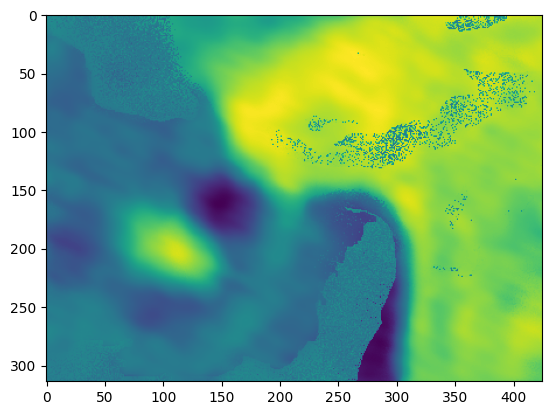

In [111]:
plt.imshow(updated_psi_mean[10,0,:,:])

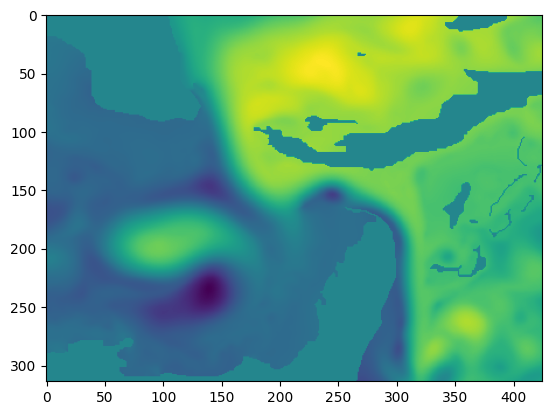

In [112]:
plt.imshow(actual_psi_test[10,0,:,:])

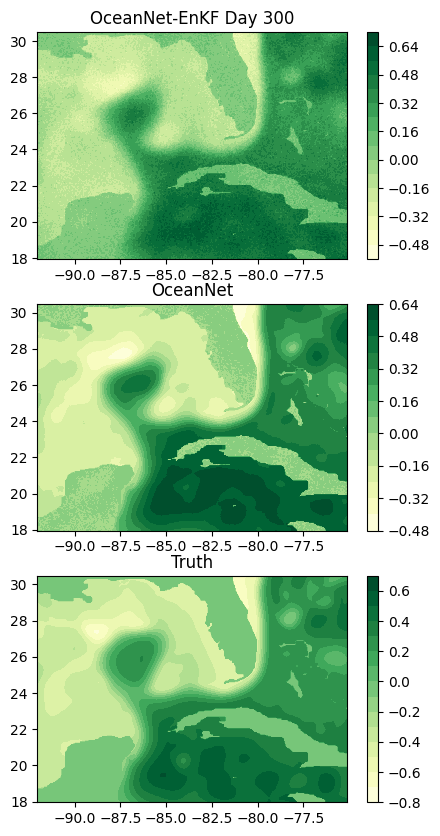

In [113]:
snap_time = 0

fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(5,10))
im = ax[0].contourf(lon_vals, lat_vals, updated_psi_mean[snap_time,0,:,:], 15, cmap='YlGn')
ax[0].set_title('OceanNet-EnKF Day 300')
plt.colorbar(im, ax=ax[0])

im1 = ax[1].contourf(lon_vals, lat_vals, autoreg_pred[snap_time,0,:,:], 15, cmap='YlGn')
ax[1].set_title('OceanNet')
plt.colorbar(im1, ax=ax[1])

im2 = ax[2].contourf(lon_vals, lat_vals, actual_psi_test[snap_time,0,:,:], 15, cmap='YlGn')
ax[2].set_title('Truth')
plt.colorbar(im2, ax=ax[2])

In [114]:
def get_landMask():
    FF=nc.Dataset(data_path + 'EnKF_surface_2020_5dmean_gom.nc')
    temp_array = np.asarray(FF['SSH'])
    land_id = np.isnan(temp_array[0,:,:])
    landmask = np.full_like(temp_array[0,:,:], 1)
    landmask[land_id] = 0.0
    
    return landmask



In [115]:
lm = get_landMask()

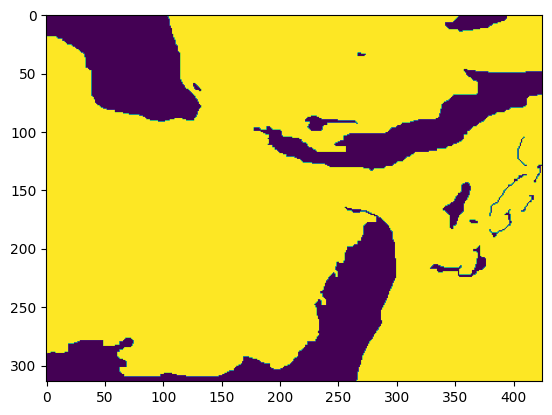

In [116]:
plt.imshow(lm)

In [117]:
updated_psi_mean.shape

(21, 1, 314, 425)

In [118]:
lm.shape

(314, 425)

In [119]:
autoreg_pred_LM = np.copy(autoreg_pred)
updated_psi_mean_LM = np.copy(updated_psi_mean)


for i in range(T+1):
    autoreg_pred_LM[i,0,:,:] = np.multiply(autoreg_pred[i,0,:,:], lm)
    updated_psi_mean_LM[i,0,:,:] = np.multiply(updated_psi_mean[i,0,:,:], lm)

In [120]:
T

20

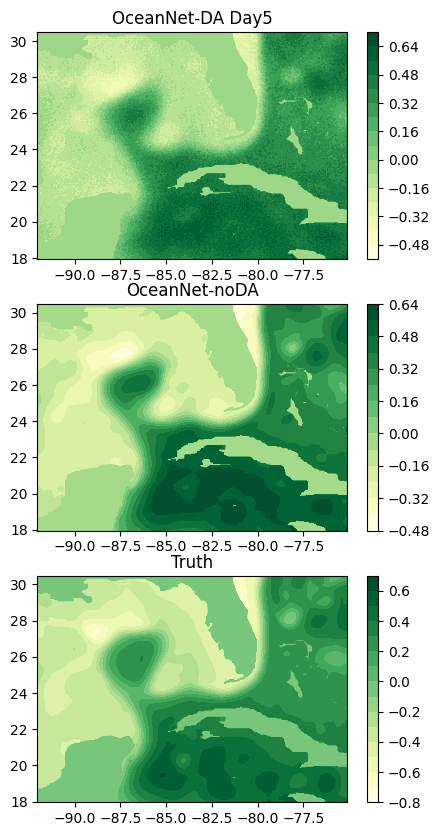

In [121]:
snap_time = 0

fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(5,10))
im = ax[0].contourf(lon_vals, lat_vals, updated_psi_mean_LM[snap_time,0,:,:], 15, cmap='YlGn')
ax[0].set_title('OceanNet-DA Day' + str((snap_time+1)*5))
plt.colorbar(im, ax=ax[0])

im1 = ax[1].contourf(lon_vals, lat_vals, autoreg_pred_LM[snap_time,0,:,:], 15, cmap='YlGn')
ax[1].set_title('OceanNet-noDA')
plt.colorbar(im1, ax=ax[1])

im2 = ax[2].contourf(lon_vals, lat_vals, actual_psi_test[snap_time,0,:,:], 15, cmap='YlGn')
ax[2].set_title('Truth')
plt.colorbar(im2, ax=ax[2])

In [122]:
arrayfile_path = '/data/ODAP_datastore/DA_results/11_01_23/'

In [123]:
str(sig_m)

'2.0'

#### Save the corresponsing results for each configuration for subsequent analysis

In [124]:
np.savez_compressed(arrayfile_path + 'OceanNet_DA_results_LM_sigma_' + str(sig_m) + '_DAcycle_' + str(DA_cycles), DA=updated_psi_mean_LM, noDA=autoreg_pred_LM, truth=actual_psi_test[:T+1,:,:,:])
np.savez_compressed(arrayfile_path + 'OceanNet_DA_results_sigma_' + str(sig_m) + '_DAcycle_' + str(DA_cycles), DA=updated_psi_mean, noDA=autoreg_pred, truth=actual_psi_test[:T+1,:,:,:])